# Data Source
1. https://github.com/ranaroussi/yfinance
2. pandas data reader yahoo

# Examples
1. [Linear Regression](https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/)
2. [Oscillate](https://www.alpharithms.com/stochastic-oscillator-in-python-483214/)
3. [AutoCorrelation](https://www.alpharithms.com/autocorrelation-time-series-python-432909/)
4. [Correlation Matrix](https://www.alpharithms.com/correlation-matrix-heatmaps-python-152514/)
5. [Transformer](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_classification_transformer.ipynb#scrollTo=wObEa-y5xT33)
6. [PyTorch-Transformer](https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e)

# References
1. [xgboost-python](https://blog.quantinsti.com/xgboost-python)
2. [xgboost-regression](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)
2. [prophet-py](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
3. [LSTM](https://colab.research.google.com/github/google-coral/tutorials/blob/master/train_lstm_timeseries_ptq_tf2.ipynb)
4. [tf timseries](https://www.tensorflow.org/tutorials/structured_data/time_series)
5. [kaggle timeseries](https://www.kaggle.com/code/nitinsss/time-series-prediction-with-keras-for-beginners)
6. [embedding](https://www.tutorialspoint.com/keras/keras_time_series_prediction_using_lstm_rnn.htm)
7. [batchNormalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/#:~:text=Keras%20provides%20support%20for%20batch%20normalization%20via%20the%20BatchNormalization%20layer.&text=The%20layer%20will%20transform%20inputs,a%20standard%20deviation%20of%20one.)

# Data Preparation

In [54]:
!pip install --upgrade pandas-datareader --quiet

## Imports

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data
from pandas_datareader import data
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sns
# For data manipulation
import pandas as pd
import numpy as np
import json 
import requests
from datetime import date


## Fetch stocks

## Peek into yahoo data

In [56]:
# Set the stock list
stock_list = ['AAPL', 'GOOG', 'AMZN', 'META']
# Set the start date and the end date
start_date = '2018-11-29'
end_date = date.today().strftime("%Y-%m-%d")
#end_date = '2022-11-30'

## Fetch the data

### Aggregations

In [57]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    # Get the data    
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    print(stock_name)
    print(df.head(1))
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    df['daily_volume_change'] = df['Volume'].pct_change()
    # df['volatility'] = (df.High - df.Low).pct_change()

    # create the features
    features = []
    for r in range(10, 60, 5):
        df['pct_change_price_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_price_'+str(r)] = df.daily_pct_change.rolling(r).std()
        df['pct_change_volume'+str(r)] = df.daily_volume_change.rolling(r).sum()
        df['std_volume_'+str(r)] = df.daily_volume_change.rolling(r).std()
        features.append('pct_change_price_'+str(r))
        features.append('std_price_'+str(r))
        features.append('pct_change_volume'+str(r))
        features.append('std_volume_'+str(r))

    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    # drop empty values
    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df}) 

# Add features
features.append('Volume')
# features.append('volatility')   

AAPL
                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2018-11-29  45.700001  44.424999  45.665001  44.887501  167080000.0  43.324326
GOOG
                High        Low       Open      Close      Volume  Adj Close
Date                                                                        
2018-11-29  54.71225  53.799999  53.804001  54.415001  29378000.0  54.415001
AMZN
                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2018-11-29  84.499496  82.616501  83.749496  83.678497  132264000.0  83.678497
META
                  High         Low        Open       Close    Volume  \
Date                                                                   
2018-11-29  139.990005  135.660004  135.919998  138.679993  24238700   

             Adj Close  
Date                    
2018-11-

In [58]:
df.tail(1)

,High,Low,Open,Close,Volume,Adj Close,daily_pct_change,daily_volume_change,pct_change_price_10,std_price_10,...,pct_change_price_50,std_price_50,pct_change_volume50,std_volume_50,pct_change_price_55,std_price_55,pct_change_volume55,std_volume_55,return_next_day,actual_signal
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-02,124.040001,117.610001,117.830002,123.489998,39875100,123.489998,0.025324,0.090932,0.10672,0.028763,...,-0.081298,0.048881,3.986057,0.461288,-0.126559,0.046838,4.294311,0.4528,-0.008584,-1


In [59]:
features

['pct_change_price_10',
 'std_price_10',
 'pct_change_volume10',
 'std_volume_10',
 'pct_change_price_15',
 'std_price_15',
 'pct_change_volume15',
 'std_volume_15',
 'pct_change_price_20',
 'std_price_20',
 'pct_change_volume20',
 'std_volume_20',
 'pct_change_price_25',
 'std_price_25',
 'pct_change_volume25',
 'std_volume_25',
 'pct_change_price_30',
 'std_price_30',
 'pct_change_volume30',
 'std_volume_30',
 'pct_change_price_35',
 'std_price_35',
 'pct_change_volume35',
 'std_volume_35',
 'pct_change_price_40',
 'std_price_40',
 'pct_change_volume40',
 'std_volume_40',
 'pct_change_price_45',
 'std_price_45',
 'pct_change_volume45',
 'std_volume_45',
 'pct_change_price_50',
 'std_price_50',
 'pct_change_volume50',
 'std_volume_50',
 'pct_change_price_55',
 'std_price_55',
 'pct_change_volume55',
 'std_volume_55',
 'Volume']

## Explore the data and the correlations

In [60]:
def show_correlations(stock_name, dataframe):
# Define a nice color map for our heatmap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(
        data=dataframe.corr(),  # our correlation matrix
        linewidths=1,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": 1}  # shrink the scale a bit
    )
  # adjust y-axis ticks for legibility
  plt.yticks(rotation=0)  
  font = {'family':'serif','color':'blue','size':20}
  plt.xlabel(stock_name, font)

  # show the heatmap
  plt.show()

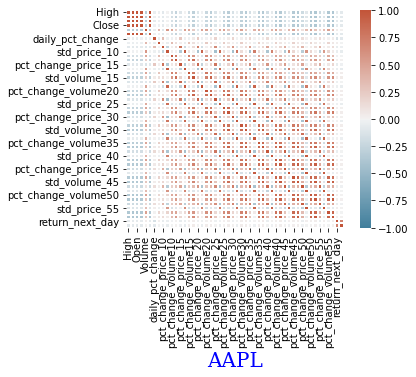

In [61]:
stock_name, df = list(stock_data_dictionary.items())[0]
show_correlations(stock_name, df)

In [62]:
df.tail(3)


,High,Low,Open,Close,Volume,Adj Close,daily_pct_change,daily_volume_change,pct_change_price_10,std_price_10,...,pct_change_price_50,std_price_50,pct_change_volume50,std_volume_50,pct_change_price_55,std_price_55,pct_change_volume55,std_volume_55,return_next_day,actual_signal
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,148.720001,140.550003,141.399994,148.029999,111224400.0,148.029999,0.048594,0.327834,-0.011083,0.023195,...,-0.038286,0.027485,1.947197,0.298020,-0.017872,0.026695,2.310303,0.316014,0.001892,1
2022-12-01,149.130005,146.610001,148.210007,148.309998,71250400.0,148.309998,0.001892,-0.359400,-0.000860,0.023066,...,-0.016127,0.027342,1.643448,0.303041,-0.025536,0.026663,2.233735,0.317636,-0.003371,-1
2022-12-02,148.000000,145.649994,145.960007,147.809998,65421400.0,147.809998,-0.003371,-0.081810,-0.017203,0.022613,...,-0.013123,0.027332,1.709571,0.302379,-0.009978,0.026546,2.123326,0.318062,-0.007983,-1


In [63]:
def show_stocks_return():
  # Set the figure size
  plt.figure(figsize=(10, 7))
  # Access the dataframe of stocks from the dictionary 
  # and then compute and plot the returns
  for stock_name in stock_list:
    (stock_data_dictionary[stock_name].daily_pct_change+1).cumprod().plot(label=stock_name+ ": daily pct change")

  # Set the title and axis labels and plot grid
  plt.title('Stock Returns')
  plt.ylabel('Cumulative Returns')
  plt.legend(loc='lower center')
  plt.grid()
  plt.show()

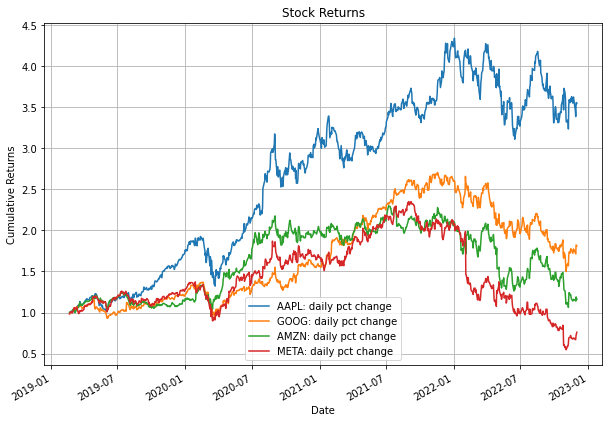

In [64]:
show_stocks_return()

## Prepare train and test data

In [65]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
split_fraction = 0.80

def normalize(data, train_length):
    data_mean = data[:train_length].mean(axis=0)
    data_std = data[:train_length].std(axis=0)
    return (data - data_mean) / data_std

# Create a placeholder for the train and test split data
for stock_name in stock_list:
  # Get predictor variables
  X = stock_data_dictionary[stock_name][features]
  train_length = int(len(X)* split_fraction)
  # X = normalize(X, train_length)
  # Get the target variable
  y = stock_data_dictionary[stock_name].actual_signal
  # Divide the dataset into train and test
  X_train = X_train.append(X[:train_length])
  X_test = X_test.append(X[train_length:])
  y_train = y_train.append(y[:train_length])
  y_test = y_test.append(y[train_length:])

X_train.shape, y_train.shape 

<ipython-input-65-52959dbe293b>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train = pd.Series()
<ipython-input-65-52959dbe293b>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test = pd.Series()


((3056, 41), (3056,))

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3056 entries, 2019-02-21 to 2022-03-02
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pct_change_price_10  3056 non-null   float64
 1   std_price_10         3056 non-null   float64
 2   pct_change_volume10  3056 non-null   float64
 3   std_volume_10        3056 non-null   float64
 4   pct_change_price_15  3056 non-null   float64
 5   std_price_15         3056 non-null   float64
 6   pct_change_volume15  3056 non-null   float64
 7   std_volume_15        3056 non-null   float64
 8   pct_change_price_20  3056 non-null   float64
 9   std_price_20         3056 non-null   float64
 10  pct_change_volume20  3056 non-null   float64
 11  std_volume_20        3056 non-null   float64
 12  pct_change_price_25  3056 non-null   float64
 13  std_price_25         3056 non-null   float64
 14  pct_change_volume25  3056 non-null   float64
 15  std_volume_25       

# XGBoost experiment

In [67]:
from xgboost import XGBClassifier, XGBRegressor, plot_importance

In [68]:
# Initialize the model and set the hyperparameter values
xgbc_model = XGBClassifier(max_depth=5, 
                      n_estimators=13, 
                      learning_rate=0.05, 
                      reg_alpha=0.55, 
                      max_delta_step=5, 
                      gamma=0.01, 
                      alpha=0.01)
xgbc_model

XGBClassifier(alpha=0.01, gamma=0.01, learning_rate=0.05, max_delta_step=5,
              max_depth=5, n_estimators=13, reg_alpha=0.55)

In [69]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=None)
# Perform K-Fold Cross Validation
results = cross_val_score(xgbc_model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 54.19% (1.04%)


In [70]:
xgbc_model.fit(X_train, y_train)


XGBClassifier(alpha=0.01, gamma=0.01, learning_rate=0.05, max_delta_step=5,
              max_depth=5, n_estimators=13, reg_alpha=0.55)

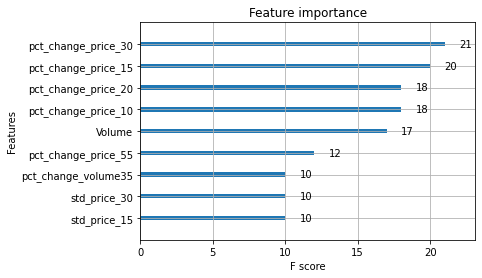

In [71]:
# Plot the top 7 features
plot_importance(xgbc_model, max_num_features=9)
# Show the plot
plt.show()

In [72]:
# Predict the trading signal on test dataset
y_pred = xgbc_model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.57      0.35      0.43       396
           1       0.51      0.72      0.60       368

    accuracy                           0.53       764
   macro avg       0.54      0.53      0.51       764
weighted avg       0.54      0.53      0.51       764



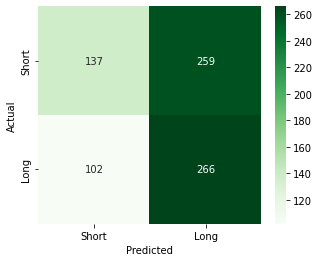

In [73]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AAPL


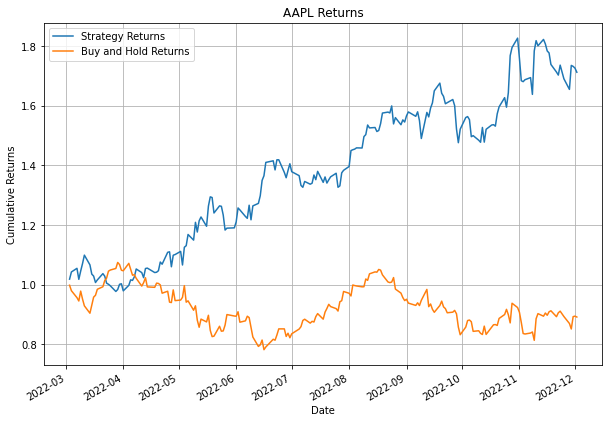

GOOG


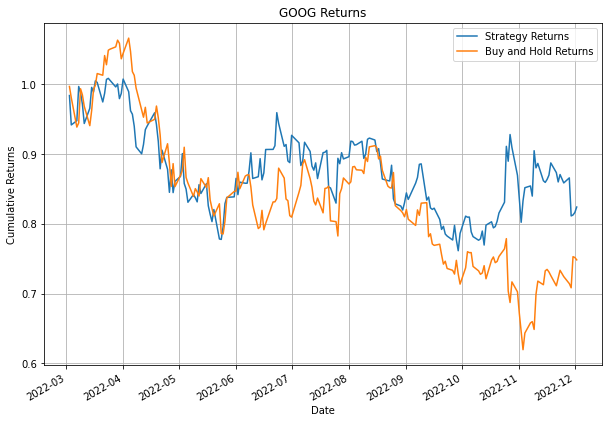

AMZN


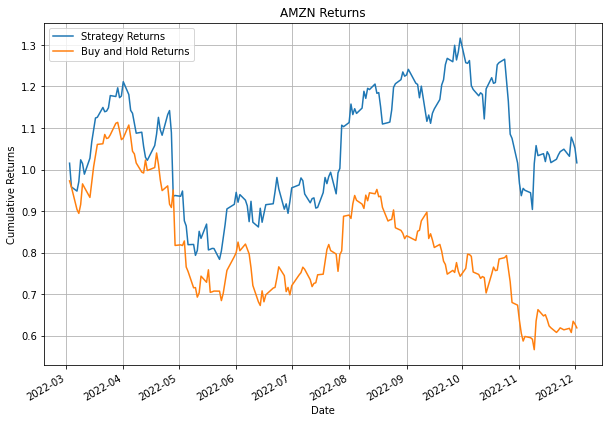

META


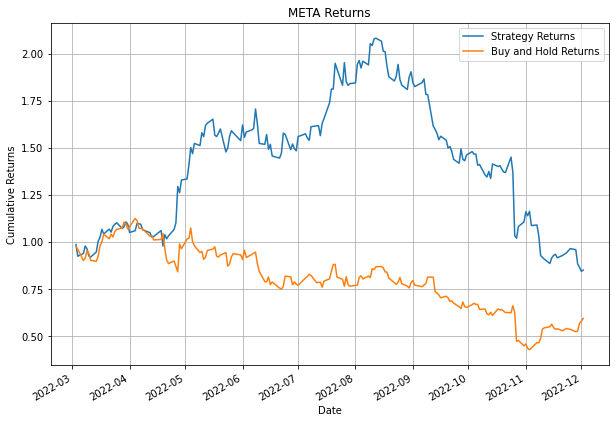

In [74]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
  # Get the data
  df = stock_data_dictionary[stock_name]
  # Store the predictor variables in X
  X = df[features]  
  # Define the train and test dataset
  train_length = int(len(X)*0.80)
  # Predict the signal and store in predicted signal column
  df['predicted_signal'] = xgbc_model.predict(X)
  # Calculate the strategy returns
  df['strategy_returns'] = df.return_next_day * df.predicted_signal
  # Add the strategy returns to the portfolio dataframe
  portfolio[stock_name] = df.strategy_returns[train_length:]
  # Plot the stock strategy and buy and hold returns
  print(stock_name)
  # Set the figure size
  plt.figure(figsize=(10, 7))
  # Calculate the cumulative strategy returns and plot
  (df.strategy_returns[train_length:]+1).cumprod().plot()
  # Calculate the cumulative buy and hold strategy returns
  (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()
  # Set the title, label and grid
  plt.title(stock_name + ' Returns')
  plt.ylabel('Cumulative Returns')
  plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
  plt.grid()
  plt.show()

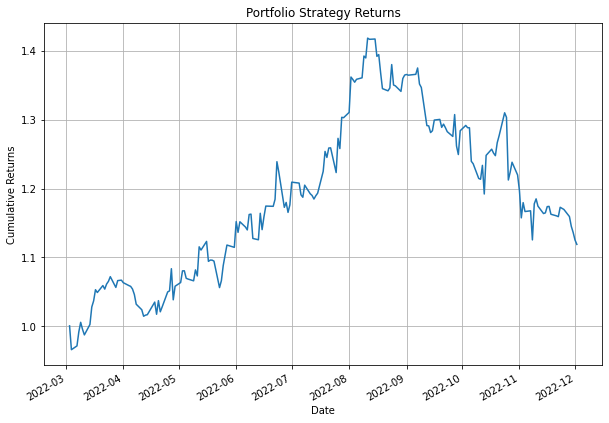

In [75]:
# Drop missing values
portfolio.dropna(inplace=True)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()
# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

# Work in progress (not fully understood yet)

#Transformer

In [103]:
import tensorflow as tf

In [131]:
X_train.shape

(3056, 41)

In [132]:
n_classes = len(np.unique(y_train))
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# y_train_np[y_train_np == -1] = 0
# y_test_np[y_test_np == -1] = 0

X_train_np.shape

(3056, 41)

In [133]:

 X_train_ns = (X_train_np.shape[0], X_train_np.shape[1], 1)
 X_test_ns = (X_test_np.shape[0], X_test_np.shape[1], 1)

X_train_ns

(3056, 41, 1)

In [134]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [135]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="tanh")(x)
    return keras.Model(inputs, outputs)

In [136]:
input_shape = X_train_ns[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    X_train_np,
    y_train_np,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 41, 1)]      0           []                               
                                                                                                  
 layer_normalization_48 (LayerN  (None, 41, 1)       2           ['input_7[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_24 (Multi  (None, 41, 1)       7169        ['layer_normalization_48[0][0]', 
 HeadAttention)                                                   'layer_normalization_48[0][0]'] 
                                                                                            

In [147]:
test_loss, test_acc = model.evaluate(X_test_np, y_test_np, verbose=1)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

24/24 [==============================] - 6s 231ms/step - loss: 7.7637 - sparse_categorical_accuracy: 0.5183
Test accuracy 0.518324613571167
Test loss 7.763689994812012


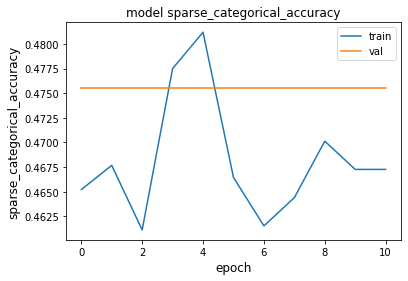

In [148]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# LSTM

In [150]:
!pip install tensorflow --upgrade --quiet
!pip install keras --upgrade --quiet

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [152]:
learning_rate = 0.001
batch_size = 64
sequence_length = 80

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train.to_numpy(),
    y_train.to_numpy(),
    sequence_length=sequence_length,
    batch_size=batch_size,
)

In [153]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test.to_numpy(),
    y_test.to_numpy(),
    sequence_length=sequence_length,
    batch_size=batch_size,
)

In [154]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 80, 41)
Target shape: (64,)


In [155]:
X_train.shape

(3056, 41)

In [156]:
inputs.shape

TensorShape([64, 80, 41])

In [158]:
from keras.layers import Dense, Input, LSTM, BatchNormalization, Dropout
from keras.models import Model

input_layer = Input(shape=(inputs.shape[1], inputs.shape[2]))
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='tanh')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 80, 41)]          0         
                                                                 
 dense_14 (Dense)            (None, 80, 60)            2520      
                                                                 
 dense_15 (Dense)            (None, 80, 60)            3660      
                                                                 
 dropout_63 (Dropout)        (None, 80, 60)            0         
                                                                 
 dense_16 (Dense)            (None, 80, 1)             61        
                                                                 
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
_________________________________________________________________


In [159]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, BatchNormalization, Dropout

def model_dnn(inputs):
    model=Sequential()
    model.add(Input(shape=(inputs.shape[1], inputs.shape[2])))
    model.add(BatchNormalization(axis=-1))
    model.add(LSTM(32, activation='tanh'))
    # model.add(Dense(1))
    # model.add(Dense(units=32, activation='relu'))
    # model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    model.summary()
    return model

model = model_dnn(inputs)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 80, 41)           164       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 32)                9472      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,669
Trainable params: 9,587
Non-trainable params: 82
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 80, 41)           164       
 ormalization)                   

In [160]:
epochs = 100

In [161]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.3582 - mse: 0.3582 - mae: 0.5327
Epoch 1: val_loss improved from inf to 0.27958, saving model to model_checkpoint.h5
47/47 [==============================] - 6s 69ms/step - loss: 0.3582 - mse: 0.3582 - mae: 0.5327 - val_loss: 0.2796 - val_mse: 0.2796 - val_mae: 0.5074
Epoch 2/100
46/47 [============================>.] - ETA: 0s - loss: 0.2619 - mse: 0.2619 - mae: 0.4886
Epoch 2: val_loss improved from 0.27958 to 0.27694, saving model to model_checkpoint.h5
47/47 [==============================] - 3s 54ms/step - loss: 0.2617 - mse: 0.2617 - mae: 0.4883 - val_loss: 0.2769 - val_mse: 0.2769 - val_mae: 0.5040
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.2516 - mse: 0.2516 - mae: 0.4871
Epoch 3: val_loss improved from 0.27694 to 0.26969, saving model to model_checkpoint.h5
47/47 [==============================] - 4s 81ms/step - loss: 0.2516 - mse: 0.2516 - mae: 0.4871 - val_loss: 0.2697 - val_ms

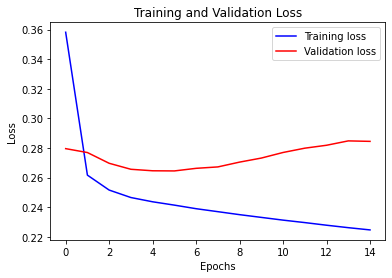

Final val loss:  [0.27957767248153687, 0.27693864703178406, 0.2696903347969055, 0.2656378746032715, 0.26462554931640625, 0.2645247280597687, 0.2662782669067383, 0.267235666513443, 0.2704803943634033, 0.2732101082801819, 0.2769818603992462, 0.27988600730895996, 0.2818564474582672, 0.28480926156044006, 0.2844843566417694]


In [162]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

In [163]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sequence_stride=int(sequence_length * 6),
    batch_size=batch_size,
)

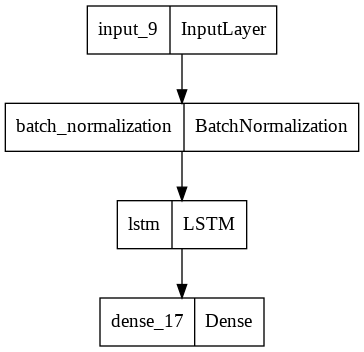

In [165]:
from keras.utils import plot_model
plot_model(model)

In [170]:
y_pred = model.predict(X_test)


TypeError: ignored

In [ ]:

model.evaluate(X_test, y_test)

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_test.take(5):
    prediction = model.predict(x)
    prediction = prediction[0]
    print('prediction:', prediction)
    print('truth:', y[0].numpy())
    show_plot(
        [x[0][:, 1].numpy(), y[0], prediction],
        12,
        "Single Step Prediction",
    )

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('timseries_forecast.tflite', 'wb') as f:
  f.write(tflite_model)

# Portfolio

In [ ]:
portfolio.shape

In [ ]:
portfolio.tail(5)

In [ ]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))

In [ ]:
data.get_sector_performance_av().head()

Prophet

In [ ]:
from prophet import Prophet

In [ ]:
p_df = pd.DataFrame()
p_df = pd.DataFrame(index=X_train.index.copy())
p_df.index.names = ['ds']
print(list(X_train.columns))
index = p_df.index
print(index)
p_df['y'] = X_train.pct_change_10
p_df['ds'] = index 
print(list(p_df.columns))
# print(X_train.loc["Date"].tail)
#p_df["ds"] = pd.to_datetime(X_train.loc[:,'Date'],format= '%H:%M:%S' ).dt.time


prophet = Prophet()
prophet.fit(p_df)


In [ ]:
future = prophet.make_future_dataframe(periods=135)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = prophet.plot(forecast)

# YFinance 

In [ ]:
!pip install yfinance --upgrade

In [ ]:
import yfinance as yf
stock_info = yf.Ticker('AAPL').info
stock_info

# market_price = stock_info['regularMarketPrice']
# previous_close_price = stock_info['regularMarketPreviousClose']
# print('market price ', market_price)
# print('previous close price ', previous_close_price)

In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    # Get the data    
    df = pdr.get_data_yahoo(stock_name, start_date, end_date)
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    df['daily_volume_change'] = df['Volume'].pct_change()

    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_price_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_price_'+str(r)] = df.daily_pct_change.rolling(r).std()
        df['pct_change_volume_'+str(r)] = df.daily_volume_change.rolling(r).sum()
        df['std_volume_'+str(r)] = df.daily_volume_change.rolling(r).std()
        predictor_list.append('pct_change_price_'+str(r))
        predictor_list.append('std_price_'+str(r))
        predictor_list.append('pct_change_volume_'+str(r))
        predictor_list.append('std_volume_'+str(r))

    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    # drop empty values
    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df}) 
  
    list_of_column_names = list(df.columns) 

#Annex

In [ ]:
!pip install pyfolio --upgrade